In [1]:
# Import Dependencies
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import requests
import time
from datetime import date
import calendar

In [2]:
# Import & Read CSV generated from DarkSky Weather API
csv_path1= "Resources/temp_weather.csv"
weather_df = pd.read_csv(csv_path1)
# Clean weather_df
del weather_df['Unnamed: 0']
del weather_df['index']

weather_df.head(1)

,Date,Temperature,Weather Condition
0,2016-02-12,20.53,Mostly Cloudy


In [3]:
# weather_df.count() shows Date has 906 non-empty rows 
#          while Temperature and Weather condition have 902 non empty rows.

# Should we add the lines: 
# weather_df = weather_df.dropna(how = 'any') 
# weather_df = weather_df.reset_index(drop = True)

 ### Stevie insert - reading in the two crime code csv's - begin

In [4]:
# Import, Read and Clean Pittsburgh Crime Codes - non drug related
csv2_path= "Resources/crime_codes.csv"
crime_code_df = pd.read_csv(csv2_path)

crime_code_df.columns= ['crime code',
                         'description ', 'statutory class','§  303.3 OFFENSE GRAVITY SCORE ', '§  303.7']

cc_df = crime_code_df[['crime code', 'statutory class']].copy()

cc_df = cc_df.dropna(how = 'any')
cc_df = cc_df.reset_index(drop = True)

i = 0
while i < len(cc_df['crime code']):
    cc_df['crime code'][i] = cc_df['crime code'][i].replace('\xa0', '')
    cc_df['crime code'][i] = cc_df['crime code'][i].replace('Inchoate', '')
    
    cc_df['statutory class'][i] = cc_df['statutory class'][i].replace('\xa0', '')
    cc_df['statutory class'][i] = cc_df['statutory class'][i].replace('Inchoate', '')
    i+=1

for x in range(len(cc_df['statutory class'])):
    cc_df['statutory class'][x] = cc_df['statutory class'][x].split('-')[0]
    cc_df['statutory class'][x] = cc_df['statutory class'][x].split(' ')[0]

classes = ['M', 'F', 'Murder']
classes = set(classes)

for x in range(len(cc_df['statutory class'])):
    if cc_df['statutory class'][x].split(' ')[0] not in classes:
        cc_df = cc_df.drop(x)

cc_df = cc_df.reset_index(drop = True)



In [5]:
# Import, Read and Clean Pittsburgh Crime Codes - drug related

csv3_path= "Resources/drug_crime_code.csv"
crime_code_df2 = pd.read_csv(csv3_path)
crime_code_df2.columns = ['crime code', 'DESCRIPTION ', 'statutory class',
       '§  303.3 OFFENSE GRAVITY SCORE ', '§  303.7']
drug_cc_df = crime_code_df2[['crime code', 'statutory class']].copy()

drug_cc_df = drug_cc_df.dropna(how = 'any')
drug_cc_df = drug_cc_df.reset_index(drop = True)


i = 0
while i < len(drug_cc_df['crime code']):
    x = drug_cc_df['crime code'][i]
    drug_cc_df['crime code'][i] = f'13{x}'
    drug_cc_df['crime code'][i] = drug_cc_df['crime code'][i].replace('\xa0', '')
    drug_cc_df['crime code'][i] = drug_cc_df['crime code'][i].replace('Inchoate', '')
    
    drug_cc_df['statutory class'][i] = drug_cc_df['statutory class'][i].replace('\xa0', '')
    drug_cc_df['statutory class'][i] = drug_cc_df['statutory class'][i].replace('Inchoate', '')
    i+=1

    
for x in range(len(drug_cc_df['statutory class'])):
    drug_cc_df['statutory class'][x] = drug_cc_df['statutory class'][x].split('-')[0]
    drug_cc_df['statutory class'][x] = drug_cc_df['statutory class'][x].split(' ')[0]
    
for x in range(len(drug_cc_df['statutory class'])):
    if drug_cc_df['statutory class'][x].split(' ')[0] not in classes:
        drug_cc_df = drug_cc_df.drop(x)    

drug_cc_df = drug_cc_df.reset_index(drop = True)    

### Stevie insert - reading in the two crime code csv's - end

In [6]:
#Import & Read Original Pittsburgh Crime Data CSV
csv_path3= "Resources/crime_data.csv"
master_df = pd.read_csv(csv_path3)
master_df.head(1)

,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y
0,1975272,16158872,42.0,F,B,2016-08-24T12:20:00,"4700 Block Centre AV Pittsburgh, PA 15213",3929 Retail Theft.,"4700 Block Centre AV Pittsburgh, PA 15213",Bloomfield,5,804.0,8.0,2.0,-79.949277,40.452551


In [7]:
# Clean master_df & Print Pittsburgh Crime DataFrame (organized_df)
# Split up ARRESTTIME column into Arrest Hour, Arrest Date, Arrest Month, Arrest Year, Arrest Unix Timestamp columns
master_df[['Date','Arrest_Time']]=master_df['ARRESTTIME'].str.split('T', expand=True,n=2)

# Drop unnecessary columns: PK, CCR, ARRESTLOCATION, OFFENSES, INCIDENTTRACT, COUNCIL_DISTRICT, PUBLIC_WORKS_DIVISION.
del master_df['PK']
del master_df['CCR']
del master_df['ARRESTTIME']
del master_df['ARRESTLOCATION']
del master_df['INCIDENTTRACT']
del master_df['COUNCIL_DISTRICT']
del master_df['PUBLIC_WORKS_DIVISION']
# Rename Columns
master_df.columns = ['Age', 'Gender', 'Race', 'Offenses Severity', 'Incident Location', 'Incident Neighborhood', 'Incident Zone', 'Incident Longitude', 'Incident Latitude', 'Date', 'Arrest_Time']
# Reorganize Columns
organized_df = master_df[['Age', 'Gender', 'Race', 'Offenses Severity', 'Date', 'Arrest_Time', 'Incident Location', 'Incident Latitude', 'Incident Longitude', 'Incident Neighborhood', 'Incident Zone']]
# View DataFrame
organized_df.head(1)

,Age,Gender,Race,Offenses Severity,Date,Arrest_Time,Incident Location,Incident Latitude,Incident Longitude,Incident Neighborhood,Incident Zone
0,42.0,F,B,3929 Retail Theft.,2016-08-24,12:20:00,"4700 Block Centre AV Pittsburgh, PA 15213",40.452551,-79.949277,Bloomfield,5


In [8]:
# Merge organized_df with weather_df
merged_df = weather_df.merge(organized_df, how="inner", on=["Date", "Date"])
merged_df.head(1)

,Date,Temperature,Weather Condition,Age,Gender,Race,Offenses Severity,Arrest_Time,Incident Location,Incident Latitude,Incident Longitude,Incident Neighborhood,Incident Zone
0,2016-02-12,20.53,Mostly Cloudy,24.0,F,B,"2701(a)(1) Simple Assault - Intent., Know., Re...",21:00:00,"1100 Block McKinney LANE Pittsburgh, PA 15205",40.423529,-80.035034,Ridgemont,6


In [9]:
# Clean & Organize merged_df
merged_df[['Arrest Year','Arrest Month','Arrest Date']]=merged_df['Date'].str.split('-', expand=True,n=2)
merged_df[['Arrest_Hour','Arrest_LongTime']]=merged_df['Arrest_Time'].str.split(':', expand=True,n=1)

# Convert "Arrest Month" column from Month Numbers to Month Names
look_up = {'01': 'January', '02': 'February', '03': 'March', '04': 'April', '05': 'May',
            '06': 'June', '07': 'July', '08': 'August', '09': 'September', '10': 'October', '11': 'November', '12': 'December'}
merged_df['Arrest Month'] = merged_df['Arrest Month'].apply(lambda x: look_up[x])

# Convert "Arrest Timestamp" column into "Arrest Day" column
merged_df['Date'] = pd.to_datetime(merged_df.Date) 
merged_df['Arrest Day of Week'] = merged_df.Date.dt.weekday_name

# Create 'Arrest Time of Day' column from 'Arrest Hour' column
merged_df["Arrest_Hour"] = pd.to_numeric(merged_df["Arrest_Hour"])
# Create bins in which to place values based upon Time of Day
day_bins = [0, 4, 8, 12, 16, 20, 24]
# Create labels for day_bins
day_labels = ["Early Morning", "Morning", "Late Morning", "Early Afternoon", "Early Evening", "Evening"]
# Create 'Arrest Time of Day' column for storing bins
merged_df['Arrest Time of Day'] = pd.cut(merged_df['Arrest_Hour'], day_bins, labels=day_labels)
# Deleter unwanted columns
del merged_df['Date']
del merged_df['Arrest_Time']
del merged_df['Arrest_LongTime']
del merged_df['Arrest_Hour']
# Reorganize columns
full_crime_df = merged_df[['Age', 'Gender', 'Race', 'Offenses Severity', 'Arrest Day of Week', 'Arrest Date', 'Arrest Month', 'Arrest Year', 'Temperature', 'Weather Condition', 'Incident Location', 'Incident Latitude', 'Incident Longitude', 'Incident Neighborhood', 'Incident Zone']]
# Show DataFrame
full_crime_df.head()

,Age,Gender,Race,Offenses Severity,Arrest Day of Week,Arrest Date,Arrest Month,Arrest Year,Temperature,Weather Condition,Incident Location,Incident Latitude,Incident Longitude,Incident Neighborhood,Incident Zone
0,24.0,F,B,"2701(a)(1) Simple Assault - Intent., Know., Re...",Friday,12,February,2016,20.53,Mostly Cloudy,"1100 Block McKinney LANE Pittsburgh, PA 15205",40.423529,-80.035034,Ridgemont,6
1,31.0,M,W,13(a)(16) Possession of Controlled Substance /...,Wednesday,17,February,2016,32.76,Overcast,"800 Block Concord ST Pittsburgh, PA 15212",40.457564,-79.997924,East Allegheny,1
2,31.0,F,O,9015 Failure To Appear/Arrest on Attachment Order,Thursday,03,March,2016,34.11,Partly Cloudy,"600 Block Liberty AV Pittsburgh, PA 15222",40.441773,-80.001620,Central Business District,2
3,22.0,M,W,2702 Aggravated Assault. / 2706 Terroristic Th...,Monday,04,April,2016,50.96,Light Rain,"S 15th ST & E Carson ST Pittsburgh, PA 15203",40.428815,-79.983425,South Side Flats,3
4,36.0,M,W,13(a)(32) Paraphernalia - Use or Possession,Friday,08,April,2016,39.39,Overcast,"Boyd ST & Diamond ST Pittsburgh, PA 15219",40.438656,-79.993293,Bluff,2


In [10]:
#same recommendation for full_crime_df as made for weather_df

### Stevie new work begin

In [11]:
full_crime_df = full_crime_df.dropna(how = 'any')
full_crime_df = full_crime_df.reset_index(drop = True)
full_crime_df.count()

Age                      25856
Gender                   25856
Race                     25856
Offenses Severity        25856
Arrest Day of Week       25856
Arrest Date              25856
Arrest Month             25856
Arrest Year              25856
Temperature              25856
Weather Condition        25856
Incident Location        25856
Incident Latitude        25856
Incident Longitude       25856
Incident Neighborhood    25856
Incident Zone            25856
dtype: int64

In [12]:
##Start of breaking offenses up just using crime codes

off_df = full_crime_df[['Offenses Severity']].copy()
off_df = off_df.reset_index(drop = True)
off_df.columns = ['OFFENSES']

#looping through and counting the number of offenses per arrest, t1 is the count of offenses per arrest
t1 = []
i = 0
while i < len(off_df["OFFENSES"]):
    t1.append(len(off_df["OFFENSES"][i].split(' / ')))
    i += 1    
off_count = np.max(t1)  

#creating columns for max number of offenses for an individual arrest and the severity of that crime
i = 1
offs = []
while i <= off_count:
    add_col1 = f'Offense {i}'
    add_col2 = f'Severity {i}'
    off_df[add_col1] = ''
    off_df[add_col2] = ''
    i+=1
    
j = 0
while j < len(off_df['OFFENSES']):
    ind_off = off_df["OFFENSES"][j].split(' / ')
    k = 0
    while k < len(ind_off):
        off_col = f'Offense {k+1}'
        off_df[off_col][j] = ind_off[k].split(' ')[0]
        k += 1
    j += 1

off_df.head()

,OFFENSES,Offense 1,Severity 1,Offense 2,Severity 2,Offense 3,Severity 3,Offense 4,Severity 4,Offense 5,...,Offense 13,Severity 13,Offense 14,Severity 14,Offense 15,Severity 15,Offense 16,Severity 16,Offense 17,Severity 17
0,"2701(a)(1) Simple Assault - Intent., Know., Re...",2701(a)(1),,5503(a)(1),,,,,,,...,,,,,,,,,,
1,13(a)(16) Possession of Controlled Substance /...,13(a)(16),,13(a)(32),,,,,,,...,,,,,,,,,,
2,9015 Failure To Appear/Arrest on Attachment Order,9015,,,,,,,,,...,,,,,,,,,,
3,2702 Aggravated Assault. / 2706 Terroristic Th...,2702,,2706,,5104,,5505,,3503.B1I,...,,,,,,,,,,
4,13(a)(32) Paraphernalia - Use or Possession,13(a)(32),,,,,,,,,...,,,,,,,,,,


In [13]:
start = time.time()
i = 0
while i < len(off_df['Offense 1']):
    j = 0
    
    while j < len(cc_df['crime code']):
        code_test1 = cc_df['crime code'][j]
        code_test2 = cc_df['crime code'][j].split('(')[0]
        if off_df['Offense 1'][i] == code_test1:
            off_df['Severity 1'][i] = cc_df['statutory class'][j]
            break
            
        elif off_df['Offense 1'][i] == code_test2:
            off_df['Severity 1'][i] = cc_df['statutory class'][j]
            break
            
  
        j += 1
    i+=1
    
x = 0
while x < len(off_df['Severity 1']):
    if off_df['Severity 1'][x] == "":
        j = 0
        
        while j < len(drug_cc_df['crime code']):
            code_test1 = drug_cc_df['crime code'][j]
            code_test2 = drug_cc_df['crime code'][j].split('(')[0]
            
            if off_df['Offense 1'][x] == code_test1:
                off_df['Severity 1'][x] = drug_cc_df['statutory class'][j]
                break
                
            elif off_df['Offense 1'][x] == code_test2:
                off_df['Severity 1'][x] = drug_cc_df['statutory class'][j]
                break
              
            j += 1
    x += 1

    end = time.time()    
    
print(f'It took {end - start} seconds to run')

off_df.head()

It took 1225.7993869781494 seconds to run


,OFFENSES,Offense 1,Severity 1,Offense 2,Severity 2,Offense 3,Severity 3,Offense 4,Severity 4,Offense 5,...,Offense 13,Severity 13,Offense 14,Severity 14,Offense 15,Severity 15,Offense 16,Severity 16,Offense 17,Severity 17
0,"2701(a)(1) Simple Assault - Intent., Know., Re...",2701(a)(1),M,5503(a)(1),,,,,,,...,,,,,,,,,,
1,13(a)(16) Possession of Controlled Substance /...,13(a)(16),M,13(a)(32),,,,,,,...,,,,,,,,,,
2,9015 Failure To Appear/Arrest on Attachment Order,9015,,,,,,,,,...,,,,,,,,,,
3,2702 Aggravated Assault. / 2706 Terroristic Th...,2702,F,2706,,5104,,5505,,3503.B1I,...,,,,,,,,,,
4,13(a)(32) Paraphernalia - Use or Possession,13(a)(32),M,,,,,,,,...,,,,,,,,,,


In [14]:
misdem_ct = 0
felon_ct = 0
murd_ct = 0
for x in off_df['Severity 1']:
    t1 = x.split('-')[0]
    t2 = x.split(' ')[0]
    if t1 == 'M':
        misdem_ct += 1
    elif t1 == 'F':
        felon_ct += 1
    elif t2 == 'Murder':
        murd_ct += 1
    
missing = len(off_df['Offense 1'])- (misdem_ct + felon_ct + murd_ct)         
print(f'We have {misdem_ct} crimes classified as a misdemeanor')
print(f'We have {felon_ct} crimes classified as a felony')
print(f'We have {murd_ct} crimes classified as a murder')
print(f'We have {missing} crimes not categorized')

We have 13109 crimes classified as a misdemeanor
We have 5382 crimes classified as a felony
We have 2 crimes classified as a murder
We have 7363 crimes not categorized


In [15]:
crime_severity_df = full_crime_df.copy()
crime_severity_df['Offenses Severity'] = off_df['Severity 1']


for x in range(len(crime_severity_df['Offenses Severity'])):
    if crime_severity_df['Offenses Severity'][x].split(' ')[0] not in classes:
        crime_severity_df = crime_severity_df.drop(x)


crime_severity_df = crime_severity_df.dropna(how = 'any')


crime_severity_df = crime_severity_df.reset_index(drop = True)
crime_severity_df.head()



,Age,Gender,Race,Offenses Severity,Arrest Day of Week,Arrest Date,Arrest Month,Arrest Year,Temperature,Weather Condition,Incident Location,Incident Latitude,Incident Longitude,Incident Neighborhood,Incident Zone
0,24.0,F,B,M,Friday,12,February,2016,20.53,Mostly Cloudy,"1100 Block McKinney LANE Pittsburgh, PA 15205",40.423529,-80.035034,Ridgemont,6
1,31.0,M,W,M,Wednesday,17,February,2016,32.76,Overcast,"800 Block Concord ST Pittsburgh, PA 15212",40.457564,-79.997924,East Allegheny,1
2,22.0,M,W,F,Monday,04,April,2016,50.96,Light Rain,"S 15th ST & E Carson ST Pittsburgh, PA 15203",40.428815,-79.983425,South Side Flats,3
3,36.0,M,W,M,Friday,08,April,2016,39.39,Overcast,"Boyd ST & Diamond ST Pittsburgh, PA 15219",40.438656,-79.993293,Bluff,2
4,60.0,M,W,M,Sunday,10,April,2016,32.63,Overcast,"Forbes AV & Armstrong TUN Pittsburgh, PA 15219",40.437971,-79.992052,Bluff,2


### Plots

In [16]:
# Weather vs  Crime Type
    # Temperature (Hot vs Cold)
        # X-Axis: Temperature (Ex. Very Cold, Cold, Moderate, Hot, Very Hot, etc.)
        # Y-Axis: count of misdem/ felon
    # Weather Condition: 
        # X-Axis: Type of weather (ie rain, sun, snow, etc.)
        # Y-Axis: count of misdem/ felon



In [17]:
stevie_plot_df = crime_severity_df[['Offenses Severity', 'Temperature', 'Weather Condition']].copy()
stevie_plot_df.head()

,Offenses Severity,Temperature,Weather Condition
0,M,20.53,Mostly Cloudy
1,M,32.76,Overcast
2,F,50.96,Light Rain
3,M,39.39,Overcast
4,M,32.63,Overcast


<function matplotlib.pyplot.show(*args, **kw)>

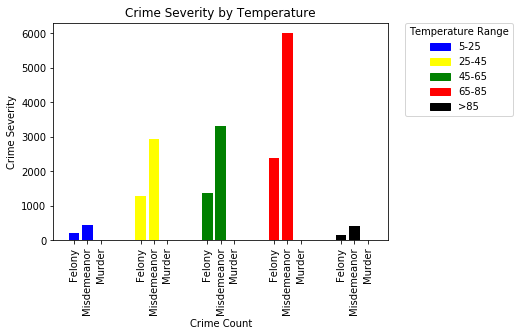

In [18]:
bins = [5,25,45,65,85,1000]
bin_names = ['5-25','25-45','45-65','65-85','>85']

stevie_plot_df['Temperature Group'] = pd.cut(stevie_plot_df["Temperature"],
                                             bins,
                                             labels=bin_names)
stevie_gp1 = stevie_plot_df.groupby(['Temperature Group','Offenses Severity'])
stevie_1_df = stevie_gp1.count()


x_pos = []
for x in range(len(bins) - 1):
    x_pos.append(x*5)
    x_pos.append(x*5+1)
    x_pos.append(x*5+2)
    
tick_labels = ['Felony', "Misdemeanor", 'Murder']
tick_labels = tick_labels *5 
tick_locations = [x for x in x_pos]

color = ['blue', 'yellow', 'green', 'red' , 'black']
colors = []
for x in color:
    colors.append(x)
    colors.append(x)
    colors.append(x)

plt.bar(x_pos,
        stevie_1_df['Temperature'],
        color = colors
       )

plt.xticks(tick_locations,
           tick_labels,
           rotation = 'vertical'
          )

plt.title('Crime Severity by Temperature')

plt.xlabel('Crime Count')
plt.ylabel('Crime Severity')

patches = []
for x, y in zip(color, bin_names):
    patches.append(mpatches.Patch(color= x, label= y))
    
plt.legend(title = 'Temperature Range',
           handles=patches,
           bbox_to_anchor=(1.05, 1),
           loc=2,
           borderaxespad=0.)
plt.show


In [32]:
# stevie_gp2 = stevie_plot_df.groupby(['Weather Condition','Offenses Severity'])
# stevie_2_df = stevie_gp2.count()

# x_pos2 = [-1]
# for x in range(len(stevie_plot_df['Weather Condition'].unique())):
#     x_pos2.append(x*5)
#     x_pos2.append(x*5+1)

# heights2 = []    
# i = 0
# while i < len(stevie_2_df['Temperature']):
#     heights2.append(stevie_2_df["Temperature"][i])
#     i += 1
    
    
    
    
    
    
# tick_labels2 = ['Felony', "Misdemeanor", 'Murder']
# tick_labels2 = tick_labels * len(stevie_plot_df['Weather Condition'].unique())
# tick_locations2 = [x for x in x_pos2]


# #### WILL NEED 15 DIFFERENT COLORS TO FORMAT LIKE ABOVE
# # color2 = ['blue', 'yellow', 'green', 'red' , 'black']
# # colors2 = []
# # for x in color2:
# #     colors2.append(x)
# #     colors2.append(x)
# #     colors2.append(x)

# plt.bar(x_pos, heights2)
# #        color = colors
# #       )

# plt.xticks(tick_locations,
#            tick_labels,
#            rotation = 'vertical'
#           )

# plt.title('Crime Severity by Temperature')

# plt.xlabel('Crime Count')
# plt.ylabel('Crime Severity')

# # patches = []
# # for x, y in zip(color, stevie_plot_df['Weather Condition'].unique()):
# #     patches.append(mpatches.Patch(color= x, label= y))
    
# plt.legend(title = 'Weather Condition',
# #           handles=patches,
#            bbox_to_anchor=(1.05, 1),
#            loc=2,
#            borderaxespad=0.)
# plt.show

In [34]:
# stevie_2_df["Temperature"][30]
stevie_plot_df['Weather Condition'].unique()


# len(heights2) - len(x_pos2)
# heights2
# x_pos2

array(['Mostly Cloudy', 'Overcast', 'Light Rain', 'Clear',
       'Partly Cloudy', 'Humid and Mostly Cloudy', 'Humid',
       'Humid and Overcast', 'Drizzle', 'Humid and Partly Cloudy', 'Rain',
       'Foggy', 'Light Snow', 'Snow', 'Flurries'], dtype=object)

### Stevie new work end

In [21]:
# Weather vs Crime Frequency / Crime Type
    # Temperature (Hot vs Cold)
        # X-Axis: Temperature (Ex. Very Cold, Cold, Moderate, Hot, Very Hot, etc.)
        # Y-Axis: Amount of Crime (measured by incident number)
    # Weather Condition: 
        # X-Axis: Type of weather (ie rain, sun, snow, etc.)
        # Y-Axis: Amount of Crime (measured by incident number)


In [22]:
# Crime Frequency vs Incident Location (Heatmap) (Liam)
    # Crime Frequency vs Police Zone (Heatmap) (Liam)


In [23]:
# Crime Severity vs Incident Location (Heatmap) (Liam)


In [24]:
# Age, Gender and Race vs Crime (Pie Charts?)
    # Crime Frequency
        # Grouped by incident location & date
    
    # Crime Type
    
    # Crime Severity (Felonies, Misdemeanors or Violations/Infractions)


In [25]:
#PH# Crime Frequency vs Time of Year (seasonality)

# Split data into groups based upon day of week
#month_groups = organized_df.groupby('Arrest Month').sum()

#sorter2 = ['January', 'Febraury', 'March', 'April', 'May', 'June', 
#          'July', 'August', 'September', 'October', 'November', 'December']
#sorterIndex = dict(zip(sorter2,range(len(sorter2))))

#month_groups['Month_id'] = month_groups.index
#month_groups['Month_id'] = month_groups['Month_id'].map(sorterIndex)
#month_groups.sort_values('Month_id', inplace=True)

#fig, ax = plt.subplots(facecolor='white')
 
#ax.bar(month_groups.Month_id, month_groups.Criminal)
#ax.set_xticks(month_groups.Month_id)
#ax.set_xticklabels(month_groups.index)

# Edit
    # Change Colors
    # Make Labels Diagonal
    # Change Y-Axis meaurements

In [26]:
# Crime Severity vs Time of Year (seasonality)
#Arrest month vs len(grouped(Incident Severity))
# X-Axis: Months
# Y-Axis: Severity of Crime (measured by incident number)


In [27]:
#PH# Crime Frequency vs Day of Week

# Split data into groups based upon day of week
#day_groups = organized_df.groupby('Arrest Day of Week').sum()

#sorter = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
#sorterIndex = dict(zip(sorter,range(len(sorter))))

#day_groups['Day_id'] = day_groups.index
#day_groups['Day_id'] = day_groups['Day_id'].map(sorterIndex)
#day_groups.sort_values('Day_id', inplace=True)

#fig, ax = plt.subplots(facecolor='white')
 
#ax.bar(day_groups.Day_id, day_groups.Criminal)
#ax.set_xticks(day_groups.Day_id)
#ax.set_xticklabels(day_groups.index)


In [28]:
# Crime Severity vs Day of Week
#Arrest Day of Week vs len(grouped(Incident Severity))
# X-Axis: Day (Monday, Tuesday, Wednesday, etc.)
# Y-Axis: Severity of Crime (measured by incident type)


In [29]:
#PH# Crime Frequency vs Time of Day 

# Split data into groups based upon day of week
#time_of_day_groups = organized_df.groupby('Arrest Time of Day')
# Find out how many arrests occured during each month group
#incidents_time_of_day = time_of_day_groups['Criminal'].count()
# Chart our data, give it a title, and label the axes
#incidents_time_of_day_chart = incidents_time_of_day.plot(kind="bar", title="Crime Frequency vs. Time of Day")
#incidents_time_of_day_chart.set_xlabel("Time of Day")
#incidents_time_of_day_chart.set_ylabel("Amount of Crime (Per Incident)")
#plt.xticks(rotation = 45)


#plt.tight_layout()

# Edit
# Change Colors
# Make Labels Diagonal
# Change Y-Axis meaurements

In [30]:
# Crime Severity vs Time of Day 
# X-Axis: Time of Day (early morning, morning, early afternoon, noon, etc.)
# Y-Axis: Severity of Crime (measured by incident type)
